## Dynamics of a fluctuating source

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys
import time

import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append('../..')
from display import cm, format_axis, format_str, props
from ode import ODE, LotkaVolterra
from cxs import CXSPoint

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [3]:
image_dir = '_images/'
model_dir = '_models/'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Simulate time series data

In [4]:
method = 'dopri5'
adjoint = False

args = {'N': 400,
        'L': 2.,
        'R': 0.07,
        'alpha': 1./3,
        'beta': 2./3,
        'gamma': 0.5,
        'delta': 0.5
       }
M = 100

lv = LotkaVolterra(args, method, default_type)
lv.init_state(M)
lv.to(device)

tf = 16
T = tf//2 + 1
t = torch.linspace(0, tf, T)
print('T:', T)

lv.solve(t, device=device)

T: 9
Elapsed time: 0.12 s


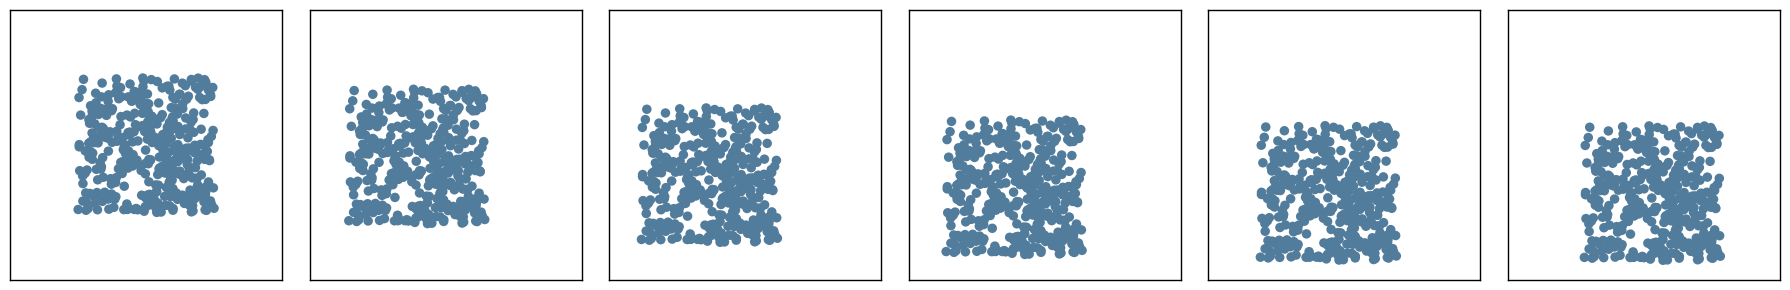

In [5]:
fig = lv.plot_series(lv.y[:6,0], ntype='none')

Detector: 56 x 56 	Probe: 9 x 9


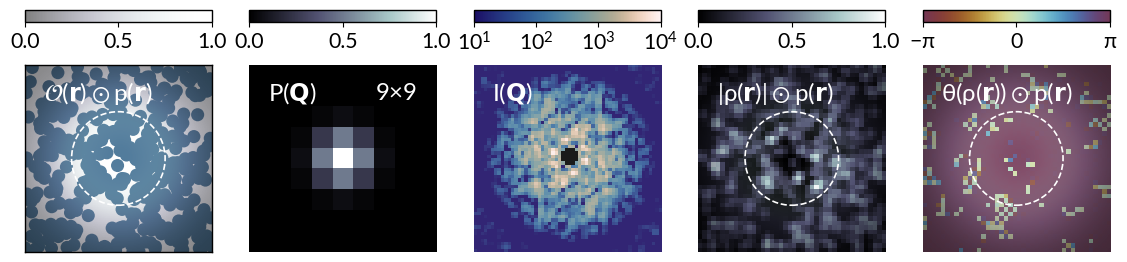

In [6]:
n = 42
dq = 0.75
f_probe = 0.25
f_mask = 0.05
c = [1.,0.]
lmax = 0
name = '_'.join([k + format_str(v) for (k,v) in zip(['n', 'dq', 'f', 'lmax'], [n, dq, f_probe, lmax])])

cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask, c=c).to(device)
cxs.shapes()

if lmax:
    vmin = 10**(np.log10(lmax) - 3)
    vmax = lmax
else:
    vmin, vmax = 1e1, 1e4
fig = cxs.plot_example(lv, lv.y0[0], lmax=lmax, vmin=vmin, vmax=vmax)
#fig.savefig(image_dir + 'lotka_example_' + name + '.png', bbox_inches='tight', dpi=400, transparent=True)

In [7]:
batch_time = T
batch_size = 1
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
t1 = time.time()
Y_batch = cxs(y_batch)

if lmax:
    Y_batch *= lmax/Y_batch.max()
    Y_batch = torch.poisson(Y_batch)
    
t2 = time.time()
print('Elapsed time: {:.3f} s'.format(t2 - t1))

 t: torch.Size([9])
y0: torch.Size([1, 400, 2])
 y: torch.Size([9, 1, 400, 2])
Elapsed time: 0.000 s


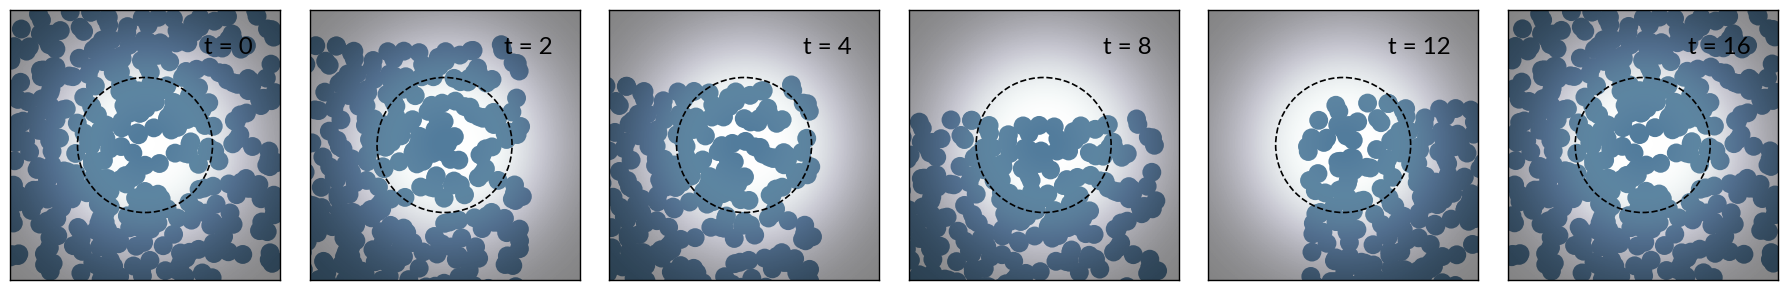

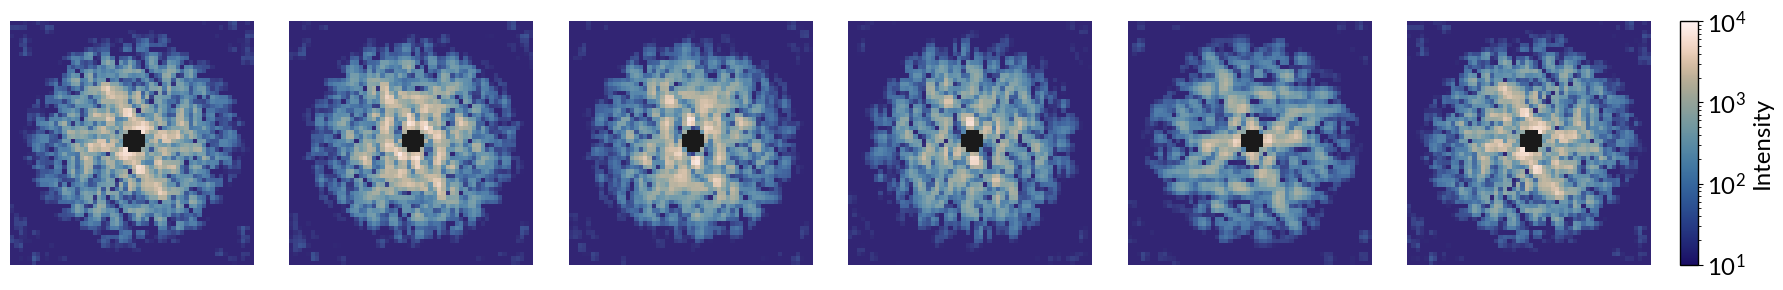

In [8]:
i_eval = np.array([0,1,2,4,6,8])
t_eval = np.round(lv.t[i_eval].numpy()).astype(int)

fig = lv.plot_series(y_batch[i_eval,0], ntype='none')
for ax in fig._localaxes:
    cxs.plot_probe(ax, ec='black')
for i, ax in enumerate(fig._localaxes):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_dir + 'lotka_real_example.png', dpi=400, bbox_inches='tight', transparent=True)

fig = lv.plot_series(Y_batch[i_eval,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=vmin, vmax=vmax, clabel='Intensity')

### Define neural ODE model

In [9]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True, default_type=default_type)
        
        default_args = {'L': 2.,
                        'R': 0.05,
                        'n': 42,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                        'c': [1.,0.],
                        'lmax': 0
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSPoint(self.R, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, c=self.c)

        self.F = nn.Sequential(
            nn.Linear(2,10),
            nn.LeakyReLU(),
            nn.Linear(10,10),
            nn.LeakyReLU(),
            nn.Linear(10,10),
            nn.LeakyReLU(),
            nn.Linear(10,10),
            nn.LeakyReLU(),
            nn.Linear(10,2)
        )
        
        
    def loss(self, y_pred, y_true):
        Y_true = self.cxs(y_true).flatten(start_dim=1)
        Y_pred = self.cxs(y_pred).flatten(start_dim=1)
        
        if self.lmax:
            # Scattering with poisson noise
            C = self.lmax/Y_true[0].max(dim=-1, keepdim=True)[0]
        
            Y_true = C*Y_true
            Y_pred = C*Y_pred
        
            Y_true = torch.poisson(Y_true)
        
            if self.lmax > 1.5e1:
                loss = nn.L1Loss()
            else:
                loss = nn.PoissonNLLLoss(log_input=False, eps=1e-8)
        else:
            # Ideal scattering
            loss = nn.L1Loss()
            
        return loss(Y_pred, Y_true)
        
        
    def forward(self, t, y):
        N = y.shape[-2]
        y_mean = y.mean(dim=-2, keepdims=True)
        dy = self.F(y_mean)
        return torch.tile(dy, (1, N, 1))

In [10]:
method = 'dopri5'
adjoint = False
args = {'L': 2.,
        'R': 0.07,
        'n': 42,
        'dq': 0.75,
        'f_probe': 0.25,
        'f_mask': 0.05,
        'lmax': 0
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

Detector: 56 x 56 	Probe: 9 x 9
NODE(
  (cxs): CXSPoint(
    (probe): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1), padding=same, bias=False)
  )
  (F): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [11]:
model_path = 'T' + str(tf) + '_' + '_'.join(
    k.replace('_','') + format_str(v) for (k,v) in args.items())
image_path = image_dir + model_path + '/'
model_path = model_dir + model_path + '_0.torch'
    
print(image_path)
print(model_path)

_images/T16_L2p0_R0p07_n42_dq0p75_fprobe0p25_fmask0p05_lmax0/
_models/T16_L2p0_R0p07_n42_dq0p75_fprobe0p25_fmask0p05_lmax0_0.torch


### Train model

In [12]:
class EMA(object):
    def __init__(self, momentum=0.02):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.value = None
        self.avg = 0

    def update(self, value):
        if self.value is None:
            self.avg = value
        else:
            self.avg = self.avg*(1 - self.momentum) + value*self.momentum
        self.value = value

ema = EMA()

In [13]:
try: saved = torch.load(model_path)
except:
    chkpt = 5
    loss = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])
    ema.update(loss[-1]/ema.momentum)

In [ ]:
node.train()
max_iters = 60
warmup_iters = 0 #2*chkpt
batch_time = T
batch_size = 10
f_spike = 1

end = time.time()
j = f_spike
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_pred, y_batch)

    if (k > warmup_iters + 1) and (_loss.item() > (j + 1)*ema.avg):
        print('Restart: Loss:', _loss.item(), 'EMA:', ema.avg)
        saved = torch.load(model_path)
        chkpt = saved['chkpt']
        loss = saved['loss']
        node.load_state_dict(saved['state'])
        node.to(device)
        optimizer.load_state_dict(saved['optimizer'])
        optimizer.param_groups[0]['lr'] /= 2.
        j += 1
    
    else:
        j = f_spike
        if k > warmup_iters:
            ema.update(_loss.item())

        _loss.backward()
        optimizer.step()

        if k % chkpt == 0:
            with torch.no_grad():
                loss.append(_loss.item())
                print('Iteration: {:04d} | Total Loss: {:.6e} | Time: {:.6f}'.format(
                    k, _loss.item(), time.time() - end)) 
            
            end = time.time()
                
        if k % (10*chkpt) == 0:
            torch.save({
                'state': node.state_dict(),
                'optimizer': optimizer.state_dict(),
                'chkpt': chkpt,
                'loss': loss,
            }, model_path)

In [57]:
if not os.path.exists(image_path):
    os.makedirs(image_path)
    
torch.save({
    'state': node.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
}, model_path)

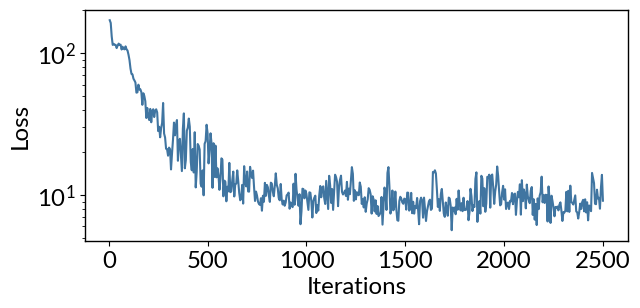

In [14]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(chkpt*np.arange(1,len(loss)+1), loss, color=cm.lapaz(100))
ax.set_yscale('log')
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
format_axis(ax, props, 'Iterations', 'Loss', ybins=4)

#fig.savefig(image_path + 'lotka_history.svg', bbox_inches='tight', transparent=True)

### Evaluate model

In [15]:
node.eval()
batch_time = T
i_eval = lv.get_eval(batch_time, n=6, d=5)
t_eval = np.round(lv.t[i_eval].numpy()).astype(int)

with torch.no_grad():
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device)
    y_diff = y_pred - y_batch
    
    Y_batch = node.cxs(y_batch[i_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[i_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    
    if node.lmax:
        Y_batch *= node.lmax/Y_batch.max()
        Y_batch = torch.poisson(Y_batch)
        Y_pred *= node.lmax/Y_pred.max()
    
    Y_diff = Y_pred - Y_batch

Elapsed time: 0.86 s


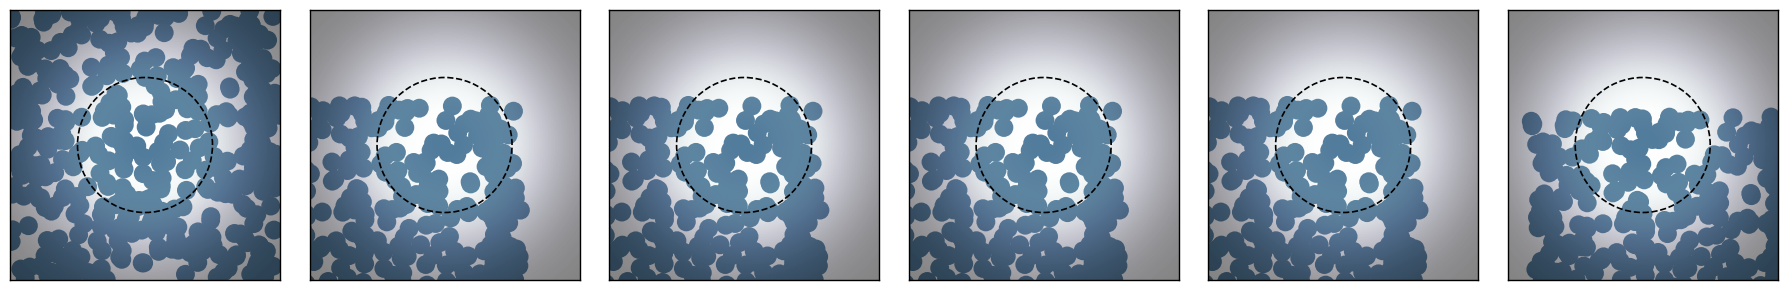

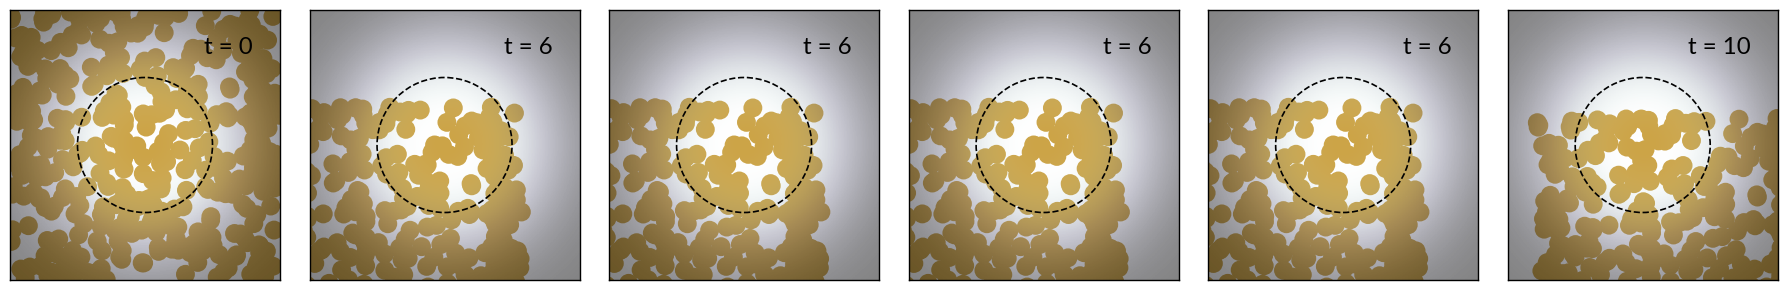

In [16]:
fig = node.plot_series(y_batch[i_eval,0], ntype='none')
for i, ax in enumerate(fig._localaxes[-7:]):
    node.cxs.plot_probe(ax, ec='black')
    
fig = node.plot_series(y_pred[i_eval,0], ntype='none', colors='#CCA447')
for i, ax in enumerate(fig._localaxes[-7:]):
    node.cxs.plot_probe(ax, ec='black')
    
for i, ax in enumerate(fig._localaxes[-7:]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)

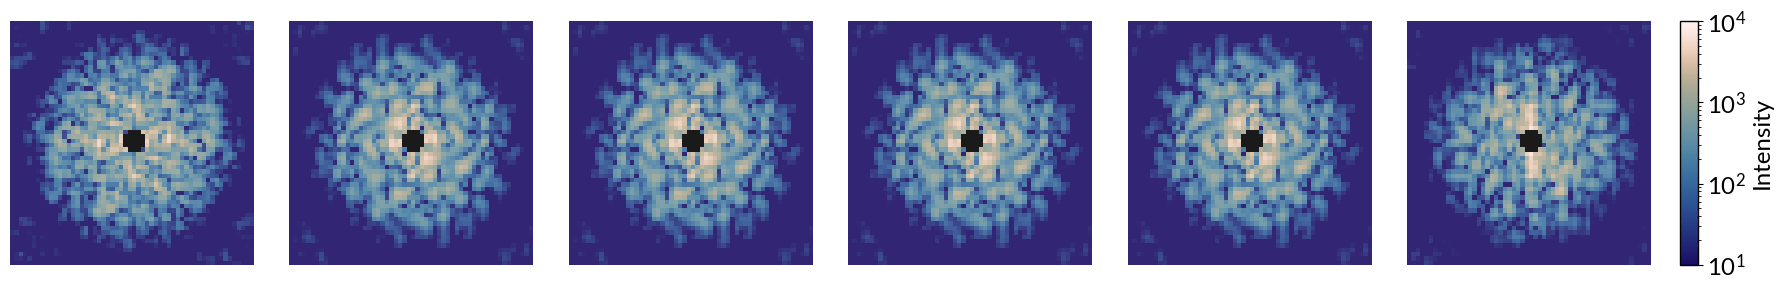

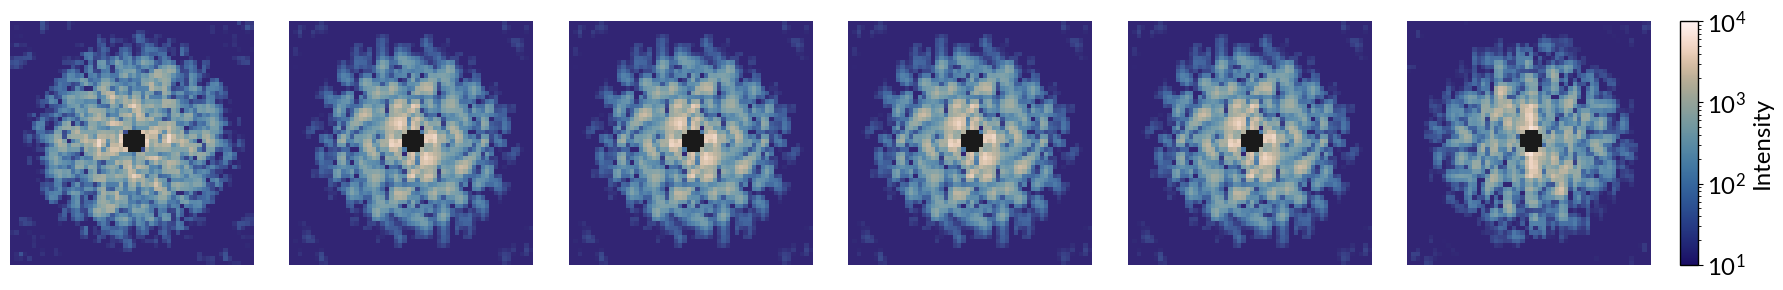

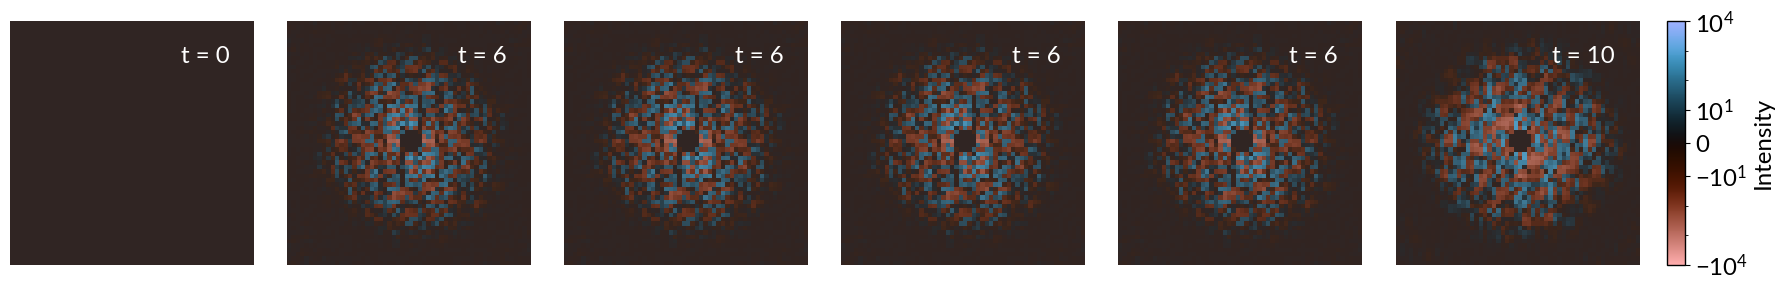

In [17]:
if node.lmax:
    vmin, vmax = 10**(np.log10(node.lmax)-3), node.lmax
else:
    vmin, vmax = 1e1, 1e4
    
fig = node.plot_series(Y_batch, ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
fig = node.plot_series(Y_pred, ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
fig = node.plot_series(Y_diff, ntype='symlog', clabel='Intensity', vmin=vmin, vmax=vmax)
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)

### Extrapolate model

In [18]:
M = 5

lv.init_state(M)
lv.to(device)

tf = 500
ntf = 1        # helps to upsample to plot smooth trajectories on dx/dt, dy/dt plots
T = ntf*tf + 1
t = torch.linspace(0, tf, T)
print('T:', T)

lv.solve(t, device=device)

T: 501
Elapsed time: 3.91 s


In [19]:
node.eval()
batch_time = T
i_eval = np.array([0,20,50,100,250,500])
t_eval = np.round(lv.t[i_eval].numpy()).astype(int)

with torch.no_grad():
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device)
    y_diff = y_pred - y_batch

    Y_batch = node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n)
        
    if node.lmax:
        Y_batch *= node.lmax/Y_batch.max()
        Y_batch = torch.poisson(Y_batch)
        Y_pred *= node.lmax/Y_pred.max()
    
    Y_diff = Y_pred - Y_batch

Elapsed time: 27.76 s


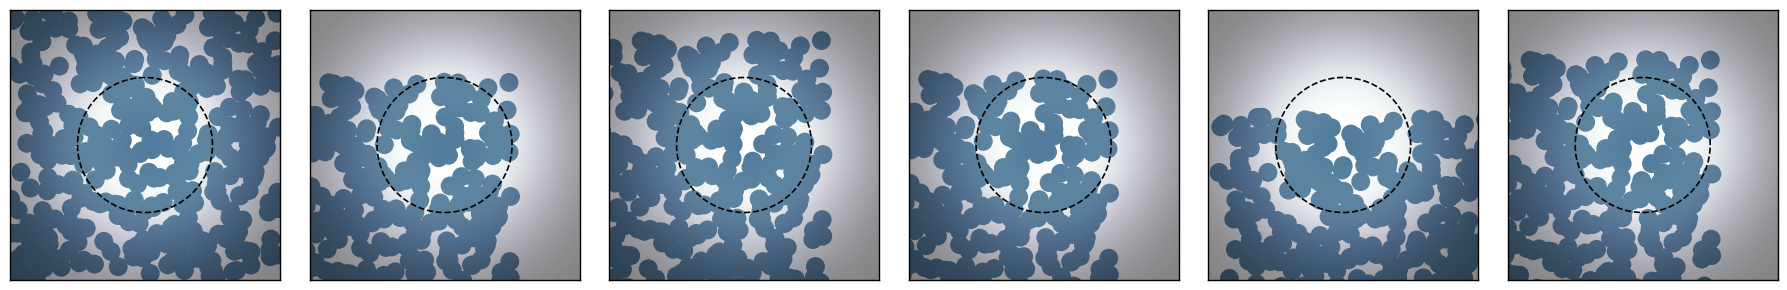

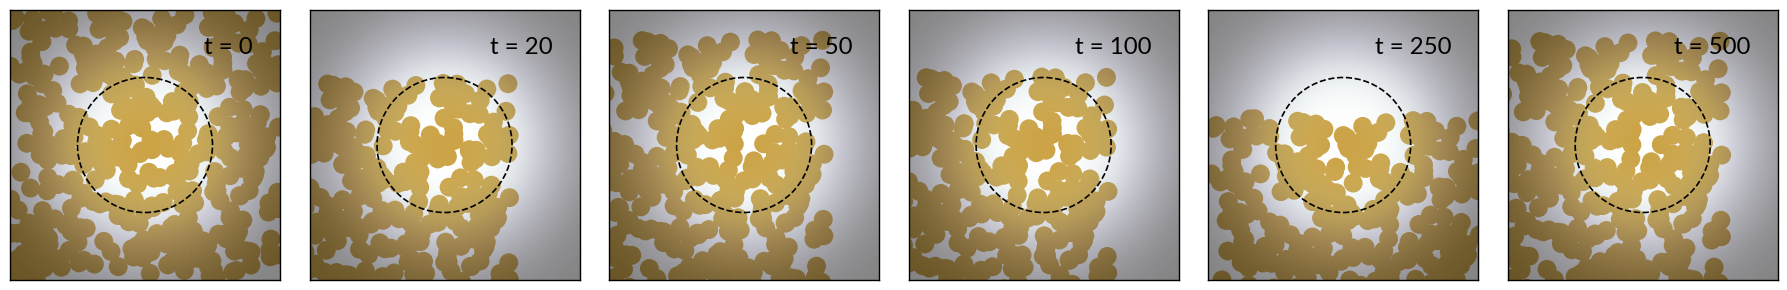

In [20]:
fig = node.plot_series(y_batch[i_eval,0], ntype='none')
for i, ax in enumerate(fig._localaxes[-7:]):
    node.cxs.plot_probe(ax, ec='black')
#fig.savefig(image_path + 'lotka_real_true.png', dpi=400, bbox_inches='tight', transparent=True)

fig = node.plot_series(y_pred[i_eval,0], ntype='none', colors='#CCA447')
for i, ax in enumerate(fig._localaxes[-7:]):
    node.cxs.plot_probe(ax, ec='black')
for i, ax in enumerate(fig._localaxes[-7:]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_path + 'lotka_real_pred.png', dpi=400, bbox_inches='tight', transparent=True)

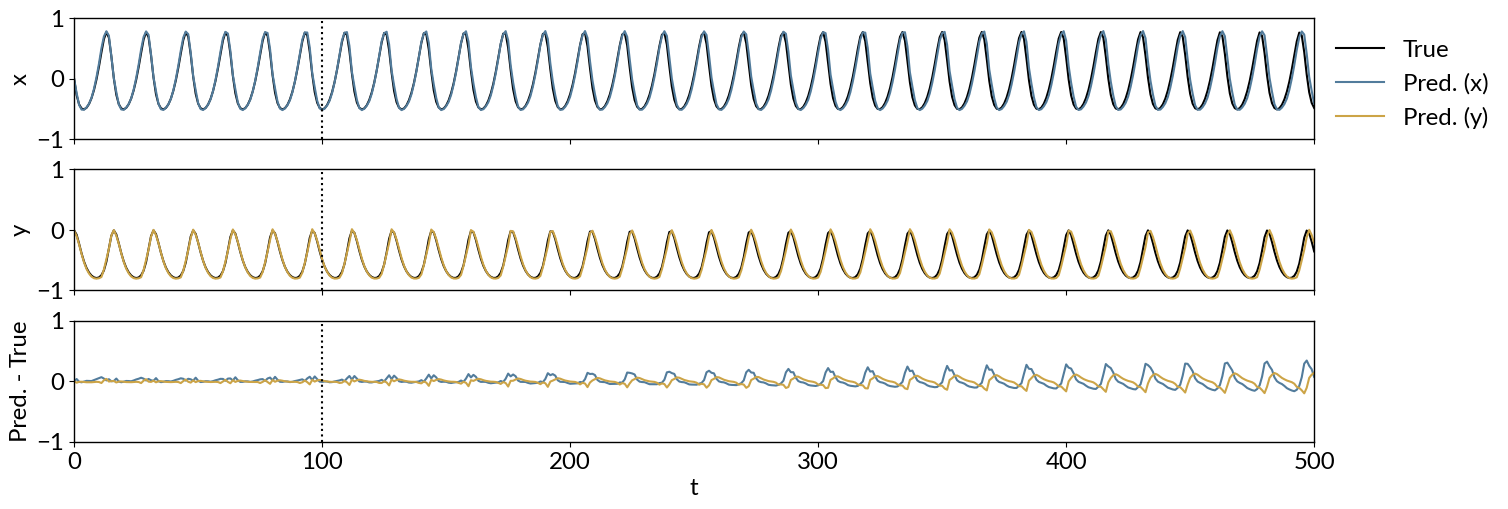

In [21]:
fig, ax = plt.subplots(3,1,figsize=(16,5.5), sharex=True)
fig.subplots_adjust(hspace=0.25)
tprops = props.copy()
tprops.set_size(props.get_size()-2)
ax[0].plot(t_batch, y_batch.mean(dim=-2).cpu()[:,0,0], color='black', label='True')
ax[0].plot(t_batch, y_pred.mean(dim=-2).cpu()[:,0,0], color='#527C9C', label='Pred. (x)')
ax[0].set_xlim([0, t_batch[-1]])
ax[0].set_ylim([-lv.L/2., lv.L/2.])
format_axis(ax[0], props, '', 'x', ybins=3)

ax[1].plot(t_batch, y_batch.mean(dim=-2).cpu()[:,0,1], color='black')
ax[1].plot(t_batch, y_pred.mean(dim=-2).cpu()[:,0,1], color='#CCA447', label='Pred. (y)')
ax[1].set_ylim([-lv.L/2., lv.L/2.])
format_axis(ax[1], props, '', 'y', ybins=3)

y_err_x = y_pred.mean(dim=-2).cpu()[:,0,0] - y_batch.mean(dim=-2).cpu()[:,0,0]
y_err_y = y_pred.mean(dim=-2).cpu()[:,0,1] - y_batch.mean(dim=-2).cpu()[:,0,1]
ax[2].plot(t_batch, y_err_x, color='#527C9C')
ax[2].plot(t_batch, y_err_y, color='#CCA447')
ax[2].set_ylim([-lv.L/2., lv.L/2.])
format_axis(ax[2], props, 't', 'Pred. - True', ybins=3)

ax[0].axvline(100, color='black', ls=':')
ax[1].axvline(100, color='black', ls=':')
ax[2].axvline(100, color='black', ls=':')

ax[0].legend(frameon=False, prop=props, loc='upper left', bbox_to_anchor=(1.,1.))
ax[1].legend(frameon=False, prop=props, loc='upper left', bbox_to_anchor=(1.,1.7))
#fig.savefig(image_path + 'lotka_trajectory.svg', bbox_inches='tight', transparent=True)

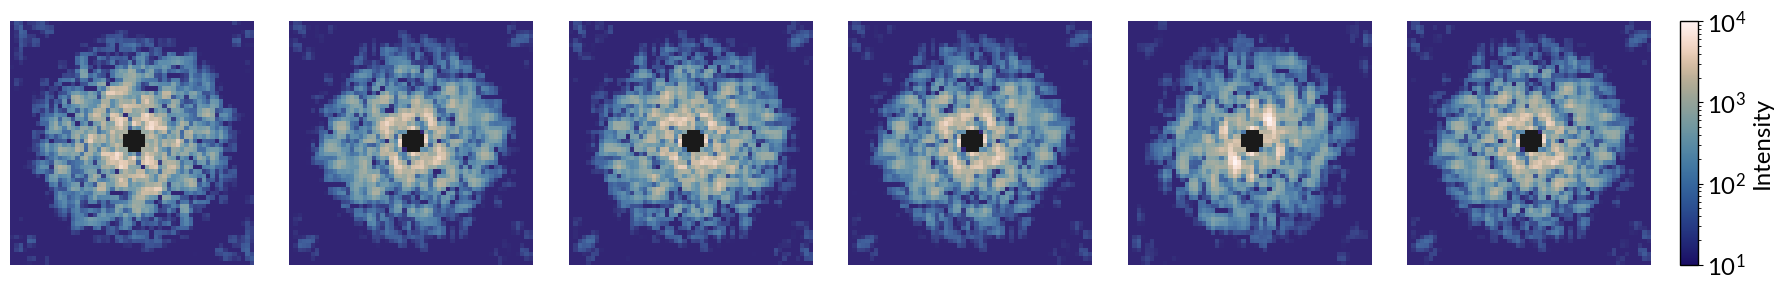

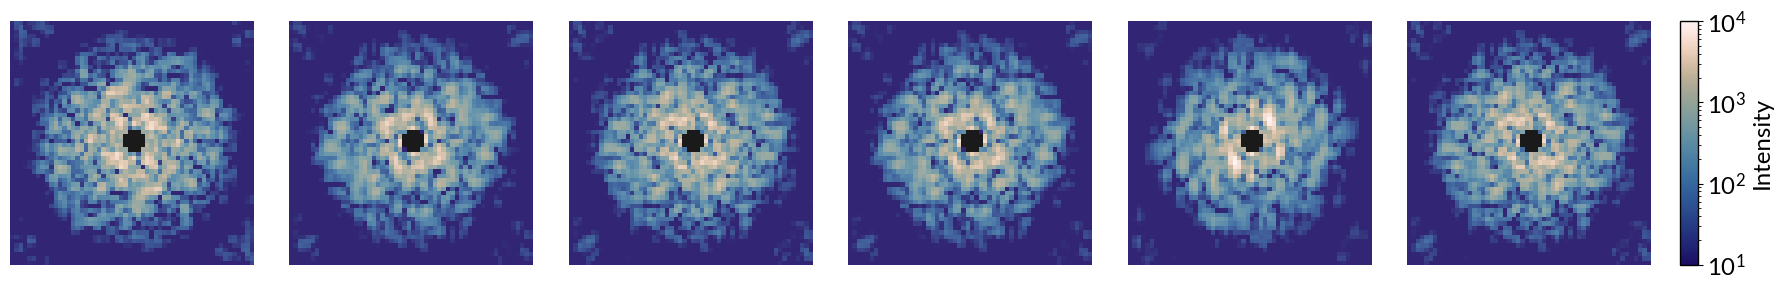

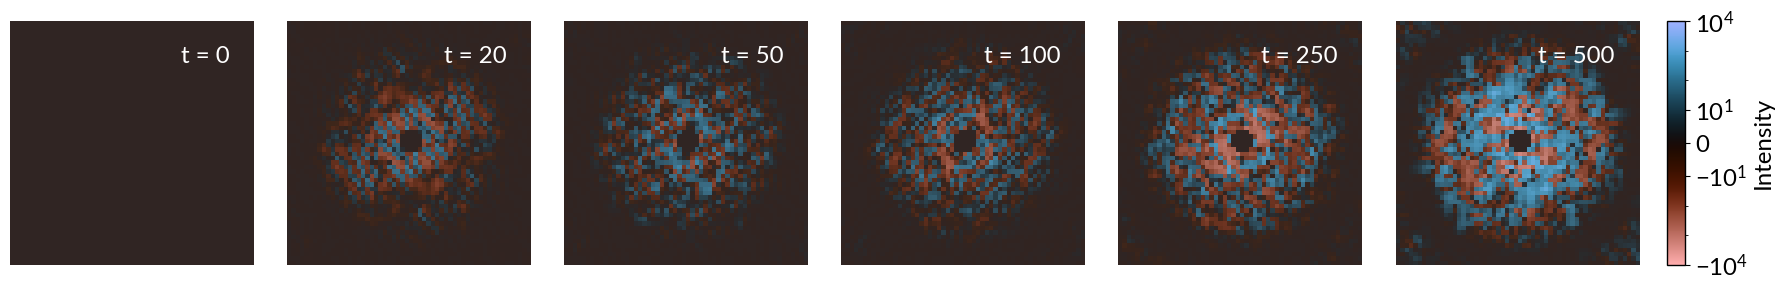

In [22]:
if node.lmax:
    vmin, vmax = 10**(np.log10(node.lmax)-3), node.lmax
else:
    vmin, vmax = 1e1, 1e4
    
fig = node.plot_series(Y_batch[i_eval], ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
#fig.savefig(image_path + 'lotka_fourier_true.png', dpi=400, bbox_inches='tight', transparent=True)

fig = node.plot_series(Y_pred[i_eval], ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
#fig.savefig(image_path + 'lotka_fourier_pred.png', dpi=400, bbox_inches='tight', transparent=True)

fig = node.plot_series(Y_diff[i_eval], ntype='symlog', clabel='Intensity', vmin=vmin, vmax=vmax)
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_path + 'lotka_fourier_diff.png', dpi=400, bbox_inches='tight', transparent=True)

### Inspect learned ODE

In [23]:
x = torch.linspace(-lv.L/2., lv.L/2., 100)
y = torch.linspace(-lv.L/2., 0*lv.L/2. + 0.05, 100)
X, Y = torch.meshgrid(x, y, indexing='xy')
t = torch.arange(1)

N = lv.N
lv.N = 1
dydt = lv(t, torch.stack((X.flatten(), Y.flatten()), dim=-1).unsqueeze(1).to(device))
dydt = dydt.cpu().numpy().reshape(X.shape + (2,))
lv.N = N

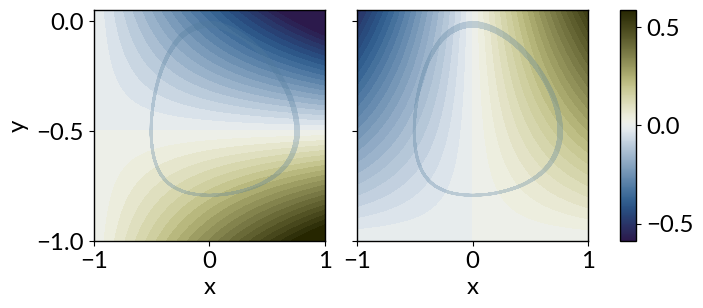

In [24]:
t_start = 0
cmap = cm.broc
vmax = 0.8*np.abs(dydt).max()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(1,3, figsize=(7,3), gridspec_kw={'width_ratios': [1,1,0.07]})
fig.subplots_adjust(wspace=0.2)
    
ax[0].contourf(X, Y, dydt[...,0], levels=50, cmap=cmap, norm=norm)
ax[1].contourf(X, Y, dydt[...,1], levels=50, cmap=cmap, norm=norm)
ax[1].set_yticklabels([])

ax[0].plot(*y_batch[t_start:,0].mean(dim=1).cpu().numpy().T, color='#527C9C', alpha=0.3)
ax[1].plot(*y_batch[t_start:,0].mean(dim=1).cpu().numpy().T, color='#527C9C', alpha=0.3)

cprops = props.copy()
cprops.set_size(14)

cbar = plt.colorbar(sm, cax=ax[-1])
for tick in cbar.ax.xaxis.get_major_ticks():
    tick.label1.set_fontproperties(cprops)
    
format_axis(ax[0], props, r'$x$', r'$y$', xbins=3, ybins=3)
format_axis(ax[1], props, r'$x$', xbins=3, ybins=3)
format_axis(ax[2], props, '', ybins=3)
#fig.savefig(image_path + 'lotka_dydt_true.png', dpi=400, bbox_inches='tight', transparent=True)

In [25]:
with torch.no_grad():
    dydt = node(t, torch.stack((X.flatten(), Y.flatten()), dim=-1).unsqueeze(1).to(device))
    dydt = dydt.cpu().numpy().reshape(X.shape + (2,))

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(7,3), gridspec_kw={'width_ratios': [1,1,0.07]})
fig.subplots_adjust(wspace=0.2)
    
ax[0].contourf(X, Y, dydt[...,0], levels=50, cmap=cmap, norm=norm)
ax[1].contourf(X, Y, dydt[...,1], levels=50, cmap=cmap, norm=norm)
ax[1].set_yticklabels([])

ax[0].plot(*y_pred[t_start:,0].mean(dim=1).cpu().numpy().T, color='#CCA447', alpha=0.3)
ax[1].plot(*y_pred[t_start:,0].mean(dim=1).cpu().numpy().T, color='#CCA447', alpha=0.3)
    
cprops = props.copy()
cprops.set_size(14)

cbar = plt.colorbar(sm, cax=ax[-1])
for tick in cbar.ax.xaxis.get_major_ticks():
    tick.label1.set_fontproperties(cprops)
    
format_axis(ax[0], props, r'$x$', r'$y$', xbins=3, ybins=3)
format_axis(ax[1], props, r'$x$', xbins=3, ybins=3)
format_axis(ax[2], props, '', ybins=3)
#fig.savefig(image_path + 'lotka_dydt_pred.png', dpi=400, bbox_inches='tight', transparent=True)